# Grounding DINO + Segment Anything Model (SAM)

Generate the bounding boxes and segmentation masks without training.

# Prerequisites

Make sure you have Python 3.9 and CUDA 11.3 or higher installed. You can check your Python and CUDA version by running:

In [1]:
!python3 --version 
!nvcc --version

Python 3.9.13
/bin/bash: nvcc: command not found


Install the required Python packages by running:

In [2]:
!cat requirements.txt | xargs -n 1 -L 1 pip install

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z7hznjc_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z7hznjc_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-ov8p_9wy/groundingdino_e772eac76a874b548708a291e698d874
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-ov8p_9wy/groundingdino_e772eac76a874b548708a291e698d874
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 60d796825e1266e56f7e4e9e00e88de662b67bd3
  Preparing metadata (setup.py) ... done


Download pretrained weights and config files for GroundingDINO and Segment Anything:

In [3]:
!wget -q -P ./input/weights/ https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q -P ./input/weights/ https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!wget -q -P ./src/ https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py


# Getting started

In [4]:
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
from typing import List, Union
import cv2
import torch
import os 
import matplotlib.pyplot as plt
import supervision as sv
from collections import namedtuple
import numpy as np
from PIL import Image
import math

/root/Documents/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

set detected object and its corresponding color:

In [5]:
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                     'has_instances', 'ignore_in_eval', 'color'])
classes_AD = [
    #CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    #CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    #CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    #CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    #CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    #CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    #CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('all road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    #CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    #CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('all building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    #CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    #CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    #CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    #CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    #CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('all sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    #CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    #CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    #CityscapesClass('license plate',        34, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    CityscapesClass('all tree',                 34, 19, 'vehicle', 7, False, True, (107, 142, 35))
    # CityscapesClass('lane lines',            35, 20, 'vehicle', 7, False, True, (128, 128, 128)),
    # CityscapesClass('wire',             36, 21, 'vehicle', 7, False, True, (0, 0, 0))
]

Change the predefined colors for the detected objects:

In [6]:
class ColorPalette_new(sv.ColorPalette):
    def __init__(self, colors):
        super().__init__(colors)
           
    @classmethod
    def default(cls):
        return ColorPalette_new.corlor_list(classes_AD)
        #return ColorPalette.from_hex(color_hex_list=DEFAULT_COLOR_PALETTE)

    @classmethod
    def corlor_list(cls,classes_AD):

        colors=[]
        for c in classes_AD:
            # if c.train_id != 255:
            colors.append(sv.Color(c.color[0],c.color[1],c.color[2]))
            # else:
            #     colors.append(Color(128,128,128))

        return cls(colors)

    def by_idx(self, idx: int):

        if idx < 0:
            raise ValueError("idx argument should not be negative")
        #idx = idx % len(self.colors)
        return self.colors[idx]
    

Change the semantic map to the Cityscapes format:

In [7]:
class MaskAnnotator_new(sv.MaskAnnotator):


    def __init__(
        self,
        color: Union[sv.Color, ColorPalette_new] = ColorPalette_new.default(),
    ):
        self.color: Union[sv.Color, ColorPalette_new] = color

    def annotate(
        self, scene, detections
    ):
        if detections.mask is None:
            return scene
        total_mask = np.zeros((scene.shape[0],scene.shape[1])).astype(np.uint8)
        for i in np.flip(np.argsort(detections.area)):
            class_id = (
                detections.class_id[i] if detections.class_id is not None else None
            )
            idx = class_id if class_id is not None else i
            color = (
                self.color.by_idx(idx)
                if isinstance(self.color, ColorPalette_new)
                else self.color
            )

            mask = detections.mask[i]
            total_mask += mask 
            colored_mask = np.zeros_like(scene, dtype=np.uint8)
            colored_mask[:] = color.as_rgb()

            scene = np.where(
            np.expand_dims(mask, axis=-1),
            np.uint8(colored_mask),
            scene)

        gray_img = np.ones_like(scene, dtype=np.uint8)*70
        scene = np.where(np.expand_dims(total_mask, axis=-1),
        scene,
        np.uint8(gray_img))

        

        return scene

In [8]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
HOME = os.getcwd()
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME,"src/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "input","weights", "groundingdino_swint_ogc.pth")
SAM_CHECKPOINT_PATH = os.path.join(HOME, "input","weights", "sam_vit_b_01ec64.pth")
DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAM_ENCODER_VERSION = "vit_b"
CLASSES = [c.name for c in classes_AD ]
IMAGE_PATH = os.path.join(HOME,"input","data","test.png")
BOX_TRESHOLD = 0.20
TEXT_TRESHOLD = 0.10
image = cv2.imread(IMAGE_PATH)

# load the models:

In [9]:
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,device = DEVICE)
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

/root/Documents/anaconda3/envs/test_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## GroundingDINO:

/root/Documents/anaconda3/envs/test_env/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/root/Documents/anaconda3/envs/test_env/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


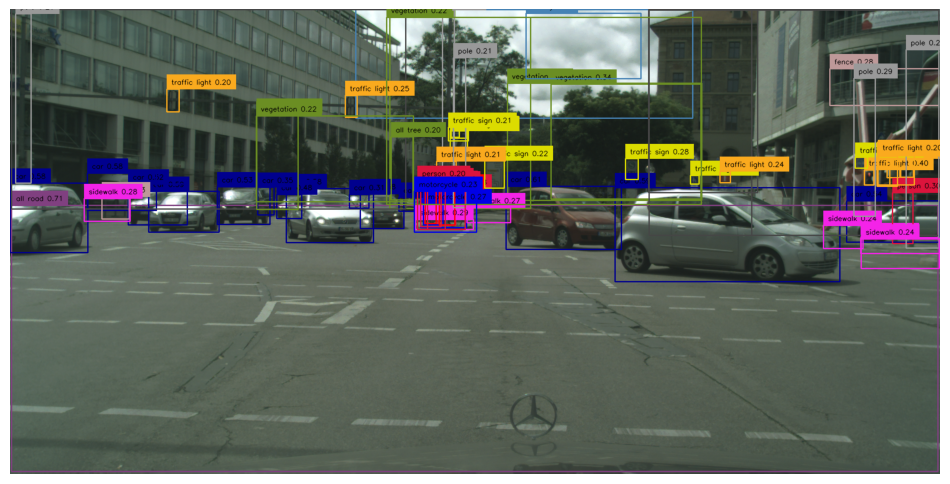

In [10]:
detections = grounding_dino_model.predict_with_classes(
    image=image,
    #classes=enhance_class_name(class_names=CLASSES),
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD)

del grounding_dino_model

box_annotator = sv.BoxAnnotator(color=ColorPalette_new.default())
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
sv.plot_image(annotated_frame)


# SAM

convert detections to masks:

In [11]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)
del sam_predictor, sam

annotate image with detections

(-0.5, 2047.5, 1023.5, -0.5)

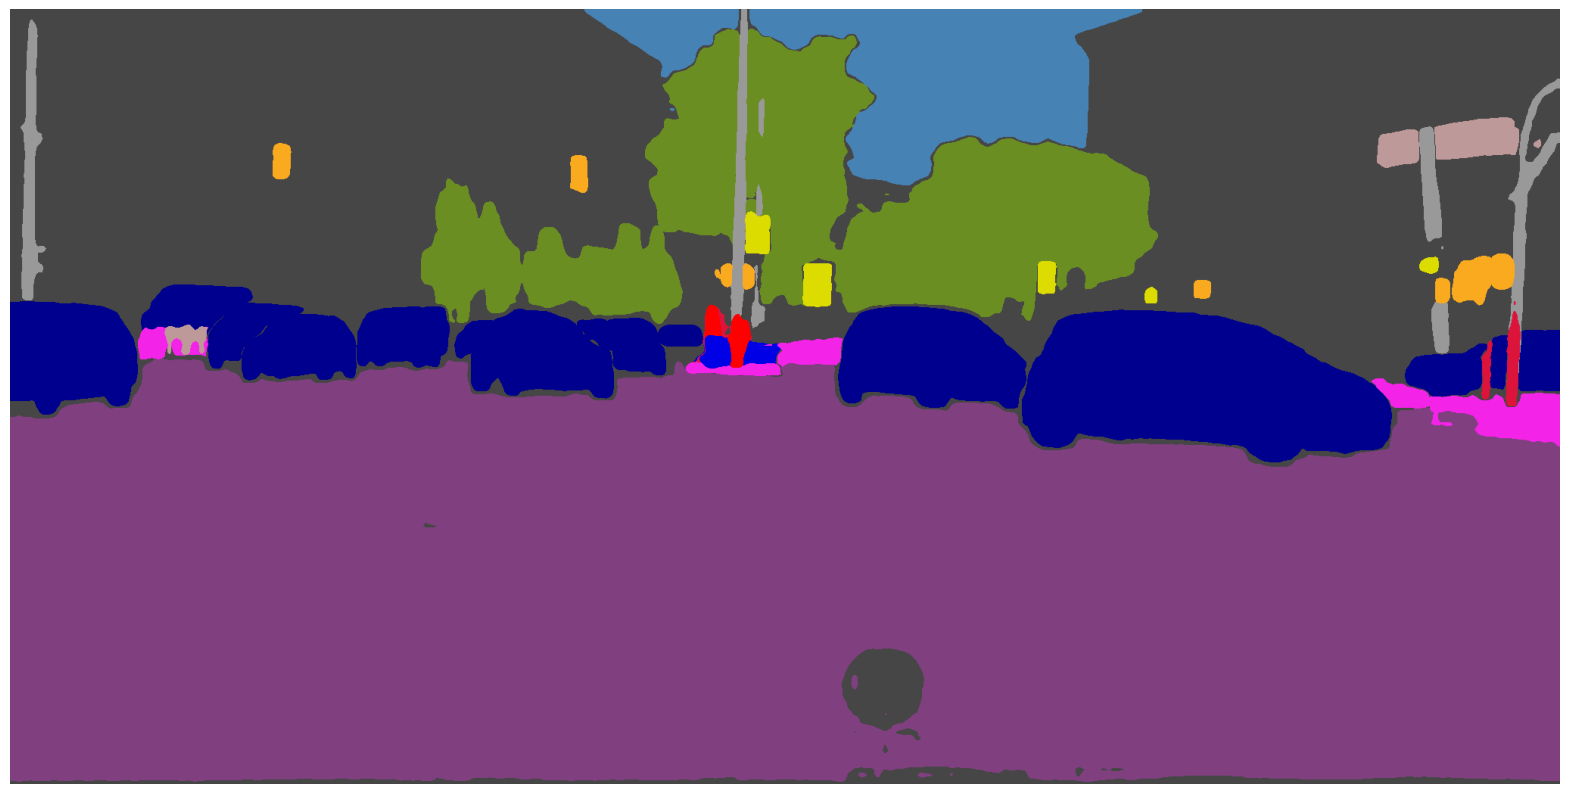

In [12]:
mask_annotator = MaskAnnotator_new(color=ColorPalette_new.default())
annotated_image_sam = mask_annotator.annotate(scene=image.copy(), detections=detections)
img = Image.fromarray(annotated_image_sam)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')

compare the results with the ground truth:

(-0.5, 2047.5, 1023.5, -0.5)

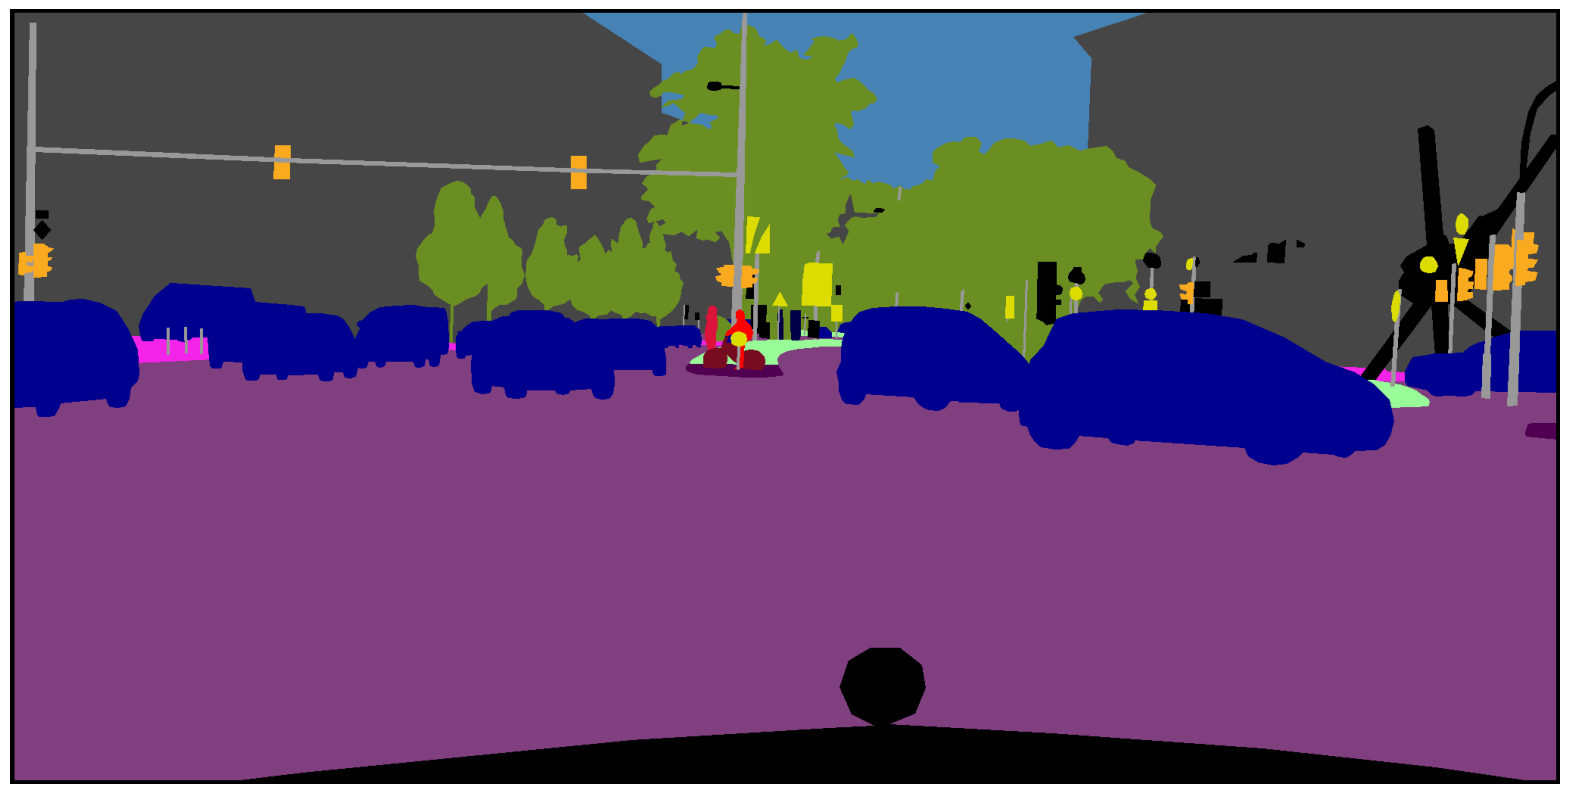

In [13]:
gt = Image.open(os.path.join(HOME,"input","data","test_gt.png"))
plt.figure(figsize=(20, 20))
plt.imshow(gt)
plt.axis('off')

# Mask generation

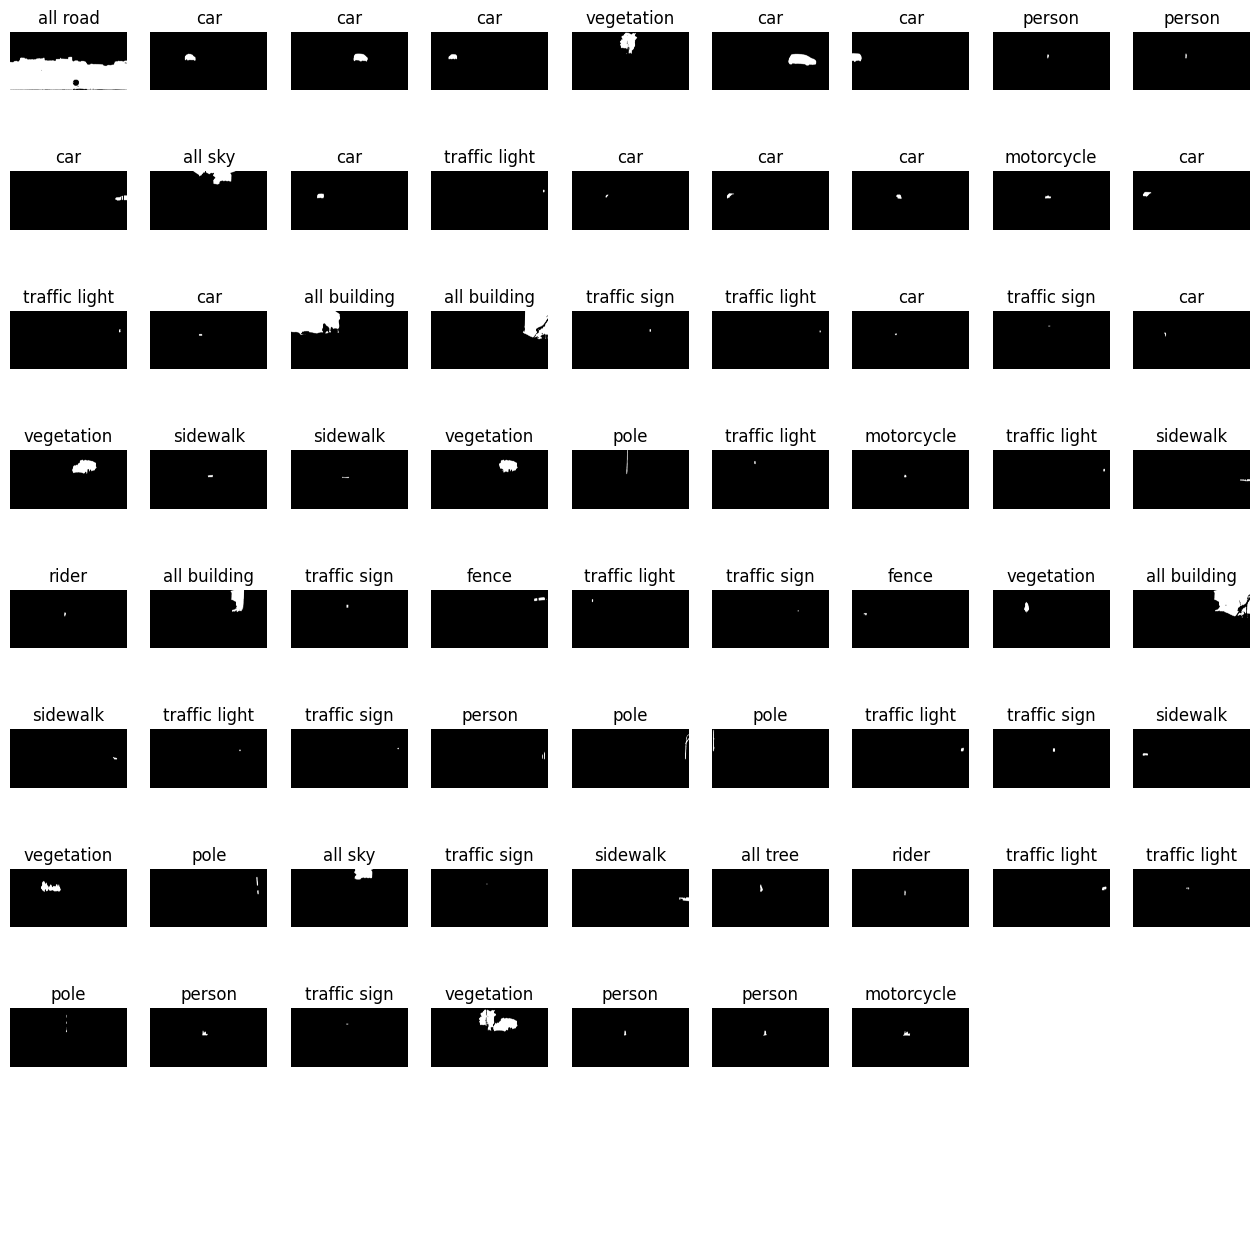

In [14]:

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16)
    )